<a href="https://colab.research.google.com/github/Cyberbullying-Detection/Cyberbullying-Detection-on-Social-Media-using-Deep-Learning-and-Conventional-Machine-learning/blob/main/Bigrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import random
from collections import defaultdict, OrderedDict
from operator import add
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from tensorflow import keras
import sklearn
import sklearn.metrics as sm
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [ ]:
file = pd.read_csv('Final Dataset/cleaned_tweets_16K.csv')
data = file.drop(['contains_url','naughty_count','norm'],axis = 1)
data.head(10)

,label_bullying,text_message
0,0,another bloody instant restaurant week serious...
1,0,this video of the peshmerga decimating isis i...
2,0,oh really no more instant restaurants thats sh...
3,0,it hasnt been a good few weeks for isis a new ...
4,0,i don’t need femisnsn because men carry heavy ...
5,0,19% is not the vast majority
6,1,and it is muslims who were the first crusader...
7,1,capital hill is a great example of how seldom...
8,1,feminismisequalitywhen men are actually listen...
9,0,gather round kids its story time brought to yo...


In [ ]:
print(file["text_message"].describe())

count     15764
unique    15294
top            
freq         18
Name: text_message, dtype: object


In [ ]:
file["text_message"].value_counts()

                                                                                    18
 yes                                                                                15
 yup                                                                                15
mkr                                                                                  8
 islamophobia - fear of this                                                         6
                                                                                    ..
 no i dont just because some tv crew went in unharmed it proves nothing              1
bullshit i dont know how many more episodes with kat and andre i could stand mkr     1
when did kat become mrburns evil mkr shameonyou                                      1
i vote for cuntandandre amp annielloyd cook off shit vs shit mkr                     1
 i highly doubt most women scare as easily as you                                    1
Name: text_message, Length: 15294, dtype: i

In [ ]:
data.value_counts

<bound method DataFrame.value_counts of        label_bullying                                       text_message
0                   0  another bloody instant restaurant week serious...
1                   0   this video of the peshmerga decimating isis i...
2                   0  oh really no more instant restaurants thats sh...
3                   0  it hasnt been a good few weeks for isis a new ...
4                   0  i don’t need femisnsn because men carry heavy ...
...               ...                                                ...
15761               1  i want equal rights but i still want your seat...
15762               1  go ahead and call me sexist but scandalous wom...
15763               0   ive had the epic but i always kept it plugged...
15764               0   so do you think that the daesh are planning t...
15765               0   my skin green no colors suit only wear ripped...

[15766 rows x 2 columns]>

In [ ]:
pd.unique(data["label_bullying"])

array([0, 1], dtype=int64)

In [ ]:
missing = data.isnull()
missing.sorted(ascending=False)

TypeError: sort_values() missing 1 required positional argument: 'by'

In [ ]:
missing = (data.isnull().sum()/len(data)*100).round(2)
pd.DataFrame({'% missing values': missing})

,% missing values
label_bullying,0.0
text_message,0.0


# Class Distribution

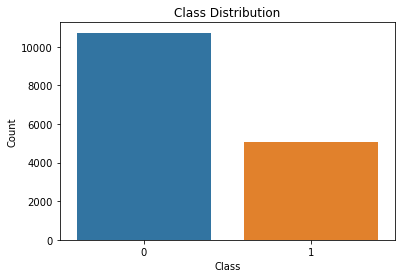

In [ ]:
ax = sns.countplot(x = 'label_bullying', data = data)
ax.set(xlabel='Class', ylabel='Count', title = 'Class Distribution')
plt.show()

In [ ]:
def shuffle_data(X, y):
    combined = list(zip(X, y))
    random.shuffle(combined)
    X[:], y[:] = zip(*combined)
    return X, y

# Get Bigrams_Data

In [ ]:
def generate_all_char_bigrams():
    bigram_dict = {}
    alphabet = 'abcdefghijklmnopqrstuvwxyz'

    for i in range(0, 26):
        for j in range(0, 26):
            gram = str(alphabet[i])+str(alphabet[j])
            bigram_dict[gram] = 0

    return OrderedDict(sorted(bigram_dict.items()))

In [ ]:
def generate_all_char_trigrams():
    bigram_dict = {}
    alphabet = 'abcdefghijklmnopqrstuvwxyz'

    for i in range(0, 26):
        for j in range(0, 26):
            for k in range(0, 26):
                gram = str(alphabet[i])+str(alphabet[j])+str(alphabet[k])
                bigram_dict[gram] = 0
    return OrderedDict(sorted(bigram_dict.items()))

In [ ]:
def get_ngram_data(ngram_size, N=20000):
    dataset_filename='Final Dataset/cleaned_tweets_16K.csv'
    X = []
    y = []
    print("\nGETTING DATA - " + str(ngram_size) + "-grams")

    # compute all possible n-grams and create a base dictionary for counting them
    if ngram_size == 2:
        global_grams = generate_all_char_bigrams()
    else:
        global_grams = generate_all_char_trigrams()
        

    # READ CSV
    with open(dataset_filename,newline='',encoding="utf8") as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:
                print(','.join(row))
            else:
                if line_count < N:
                    if line_count % 200 == 0:
                        print(str(line_count) + " ngrams computed")

                    label_bullying = int(row[0])
                    text_message = row[1]

                    # current features
                    temp_x = []
                    this_bigram_dict = global_grams.copy()

                    # split text messages into a list of its ngrams
                    ngram = [text_message[j:j+ngram_size] for j in range(len(text_message)-(ngram_size-1))]

                    # TODO: change this to 'count' so we get better performance
                    # count occurences of each character ngram
                    for gram in ngram:
                        if gram in this_bigram_dict:
                            this_bigram_dict[gram] += 1

                    # create feature vector for this instance (take just the values)
                    for key in this_bigram_dict:
                        temp_x.append(this_bigram_dict[key])

                    X.append(temp_x)
                    y.append(label_bullying)

                    del this_bigram_dict
            line_count += 1
    print("processed", line_count-1, "comments\n")

    # shuffle the data so that it is randomised
    X, y = shuffle_data(X, y)

    # SPLIT
    print("splitting...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)

    return X_train, X_test, y_train, y_test


# Logistic Regression

In [ ]:
#Logistic Regression
X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = get_ngram_data(ngram_size=2, N=69446)

grid_searching = False
clf = sklearn.linear_model.LogisticRegression(penalty="l2", max_iter=100, solver="liblinear")
clf = clf.fit(X_train_logistic, y_train_logistic)

#PREDICT
print("\nevaluating")
y_pred_logistic = clf.predict(X_test_logistic)
print(y_pred_logistic)


GETTING DATA - 2-grams
label_bullying,text_message,contains_url,naughty_count,norm
200 ngrams computed
400 ngrams computed
600 ngrams computed
800 ngrams computed
1000 ngrams computed
1200 ngrams computed
1400 ngrams computed
1600 ngrams computed
1800 ngrams computed
2000 ngrams computed
2200 ngrams computed
2400 ngrams computed
2600 ngrams computed
2800 ngrams computed
3000 ngrams computed
3200 ngrams computed
3400 ngrams computed
3600 ngrams computed
3800 ngrams computed
4000 ngrams computed
4200 ngrams computed
4400 ngrams computed
4600 ngrams computed
4800 ngrams computed
5000 ngrams computed
5200 ngrams computed
5400 ngrams computed
5600 ngrams computed
5800 ngrams computed
6000 ngrams computed
6200 ngrams computed
6400 ngrams computed
6600 ngrams computed
6800 ngrams computed
7000 ngrams computed
7200 ngrams computed
7400 ngrams computed
7600 ngrams computed
7800 ngrams computed
8000 ngrams computed
8200 ngrams computed
8400 ngrams computed
8600 ngrams computed
8800 ngrams compu

In [ ]:
# EVALUATE
print("confusion matrix:\n", sm.confusion_matrix(y_test_logistic,y_pred_logistic))
print("accuracy:", round(sm.accuracy_score(y_test_logistic,y_pred_logistic), 4))

confusion matrix:
 [[4805  486]
 [1186 1406]]
accuracy: 0.7879


# Random Forest

In [ ]:
#Random Forest
X_train_random, X_test_random, y_train_random, y_test_random = get_ngram_data(ngram_size=2, N=69446)
grid_searching = False
clf = RandomForestClassifier(n_estimators=100, max_depth=4)
clf = clf.fit(X_train_random, y_train_random)

#PREDICT
print("\nevaluating")
y_pred_random = clf.predict(X_test_random)
print(y_pred_random)


GETTING DATA - 2-grams
label_bullying,text_message,contains_url,naughty_count,norm
200 ngrams computed
400 ngrams computed
600 ngrams computed
800 ngrams computed
1000 ngrams computed
1200 ngrams computed
1400 ngrams computed
1600 ngrams computed
1800 ngrams computed
2000 ngrams computed
2200 ngrams computed
2400 ngrams computed
2600 ngrams computed
2800 ngrams computed
3000 ngrams computed
3200 ngrams computed
3400 ngrams computed
3600 ngrams computed
3800 ngrams computed
4000 ngrams computed
4200 ngrams computed
4400 ngrams computed
4600 ngrams computed
4800 ngrams computed
5000 ngrams computed
5200 ngrams computed
5400 ngrams computed
5600 ngrams computed
5800 ngrams computed
6000 ngrams computed
6200 ngrams computed
6400 ngrams computed
6600 ngrams computed
6800 ngrams computed
7000 ngrams computed
7200 ngrams computed
7400 ngrams computed
7600 ngrams computed
7800 ngrams computed
8000 ngrams computed
8200 ngrams computed
8400 ngrams computed
8600 ngrams computed
8800 ngrams compu

In [ ]:
# EVALUATE
print("confusion matrix:\n", sm.confusion_matrix(y_test_random,y_pred_random))
print("accuracy:", round(sm.accuracy_score(y_test_random,y_pred_random), 4))

confusion matrix:
 [[5301   22]
 [2073  487]]
accuracy: 0.7342


# Bernoulli Naive Bayes

In [ ]:
X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = get_ngram_data(ngram_size=2, N=69446)
grid_searching = False
clf = BernoulliNB()
clf = clf.fit(X_train_bayes, y_train_bayes)

#PREDICT
print("\nevaluating")
y_pred_bayes = clf.predict(X_test_bayes)
print(y_pred_bayes)


GETTING DATA - 2-grams
label_bullying,text_message,contains_url,naughty_count,norm
200 ngrams computed
400 ngrams computed
600 ngrams computed
800 ngrams computed
1000 ngrams computed
1200 ngrams computed
1400 ngrams computed
1600 ngrams computed
1800 ngrams computed
2000 ngrams computed
2200 ngrams computed
2400 ngrams computed
2600 ngrams computed
2800 ngrams computed
3000 ngrams computed
3200 ngrams computed
3400 ngrams computed
3600 ngrams computed
3800 ngrams computed
4000 ngrams computed
4200 ngrams computed
4400 ngrams computed
4600 ngrams computed
4800 ngrams computed
5000 ngrams computed
5200 ngrams computed
5400 ngrams computed
5600 ngrams computed
5800 ngrams computed
6000 ngrams computed
6200 ngrams computed
6400 ngrams computed
6600 ngrams computed
6800 ngrams computed
7000 ngrams computed
7200 ngrams computed
7400 ngrams computed
7600 ngrams computed
7800 ngrams computed
8000 ngrams computed
8200 ngrams computed
8400 ngrams computed
8600 ngrams computed
8800 ngrams compu

In [ ]:
# EVALUATE
print("confusion matrix:\n", sm.confusion_matrix(y_test_bayes,y_pred_bayes))
print("accuracy:", round(sm.accuracy_score(y_test_bayes,y_pred_bayes), 4))

confusion matrix:
 [[4120 1245]
 [ 926 1592]]
accuracy: 0.7246


# KNN

In [ ]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = get_ngram_data(ngram_size=2, N=69446)
grid_searching = False
clf = KNeighborsClassifier(n_neighbors=3)
clf = clf.fit(X_train_knn, y_train_knn)

#PREDICT
print("\nevaluating")
y_pred_knn = clf.predict(X_test_knn)
print(y_pred_knn)


GETTING DATA - 2-grams
label_bullying,text_message,contains_url,naughty_count,norm
200 ngrams computed
400 ngrams computed
600 ngrams computed
800 ngrams computed
1000 ngrams computed
1200 ngrams computed
1400 ngrams computed
1600 ngrams computed
1800 ngrams computed
2000 ngrams computed
2200 ngrams computed
2400 ngrams computed
2600 ngrams computed
2800 ngrams computed
3000 ngrams computed
3200 ngrams computed
3400 ngrams computed
3600 ngrams computed
3800 ngrams computed
4000 ngrams computed
4200 ngrams computed
4400 ngrams computed
4600 ngrams computed
4800 ngrams computed
5000 ngrams computed
5200 ngrams computed
5400 ngrams computed
5600 ngrams computed
5800 ngrams computed
6000 ngrams computed
6200 ngrams computed
6400 ngrams computed
6600 ngrams computed
6800 ngrams computed
7000 ngrams computed
7200 ngrams computed
7400 ngrams computed
7600 ngrams computed
7800 ngrams computed
8000 ngrams computed
8200 ngrams computed
8400 ngrams computed
8600 ngrams computed
8800 ngrams compu

In [ ]:
# EVALUATE
print("confusion matrix:\n", sm.confusion_matrix(y_test_knn,y_pred_knn))
print("accuracy:", round(sm.accuracy_score(y_test_knn,y_pred_knn), 4))

confusion matrix:
 [[4826  510]
 [1420 1127]]
accuracy: 0.7552


# AdaBoost Classifier

In [ ]:
X_train_adaboost, X_test_adaboost, y_train_adaboost, y_test_adaboost = get_ngram_data(ngram_size=2, N=69446)
grid_searching = False
clf = AdaBoostClassifier()
clf = clf.fit(X_train_adaboost, y_train_adaboost)

#PREDICT
print("\nevaluating")
y_pred_adaboost = clf.predict(X_test_adaboost)
print(y_pred_adaboost)


GETTING DATA - 2-grams
label_bullying,text_message,contains_url,naughty_count,norm
200 ngrams computed
400 ngrams computed
600 ngrams computed
800 ngrams computed
1000 ngrams computed
1200 ngrams computed
1400 ngrams computed
1600 ngrams computed
1800 ngrams computed
2000 ngrams computed
2200 ngrams computed
2400 ngrams computed
2600 ngrams computed
2800 ngrams computed
3000 ngrams computed
3200 ngrams computed
3400 ngrams computed
3600 ngrams computed
3800 ngrams computed
4000 ngrams computed
4200 ngrams computed
4400 ngrams computed
4600 ngrams computed
4800 ngrams computed
5000 ngrams computed
5200 ngrams computed
5400 ngrams computed
5600 ngrams computed
5800 ngrams computed
6000 ngrams computed
6200 ngrams computed
6400 ngrams computed
6600 ngrams computed
6800 ngrams computed
7000 ngrams computed
7200 ngrams computed
7400 ngrams computed
7600 ngrams computed
7800 ngrams computed
8000 ngrams computed
8200 ngrams computed
8400 ngrams computed
8600 ngrams computed
8800 ngrams compu

In [ ]:
# EVALUATE
print("confusion matrix:\n", sm.confusion_matrix(y_test_adaboost,y_pred_adaboost))
print("accuracy:", round(sm.accuracy_score(y_test_adaboost,y_pred_adaboost), 4))

confusion matrix:
 [[4840  497]
 [1228 1318]]
accuracy: 0.7812


# SVM

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = get_ngram_data(ngram_size=2, N=69446)
grid_searching = False
clf = svm.SVC(C=10, kernel="rbf", gamma=0.001)
clf = clf.fit(X_train_svm, y_train_svm)

#PREDICT
print("\nevaluating")
y_pred_svm = clf.predict(X_test_svm)
print(y_pred_svm)


GETTING DATA - 2-grams
label_bullying,text_message,contains_url,naughty_count,norm
200 ngrams computed
400 ngrams computed
600 ngrams computed
800 ngrams computed
1000 ngrams computed
1200 ngrams computed
1400 ngrams computed
1600 ngrams computed
1800 ngrams computed
2000 ngrams computed
2200 ngrams computed
2400 ngrams computed
2600 ngrams computed
2800 ngrams computed
3000 ngrams computed
3200 ngrams computed
3400 ngrams computed
3600 ngrams computed
3800 ngrams computed
4000 ngrams computed
4200 ngrams computed
4400 ngrams computed
4600 ngrams computed
4800 ngrams computed
5000 ngrams computed
5200 ngrams computed
5400 ngrams computed
5600 ngrams computed
5800 ngrams computed
6000 ngrams computed
6200 ngrams computed
6400 ngrams computed
6600 ngrams computed
6800 ngrams computed
7000 ngrams computed
7200 ngrams computed
7400 ngrams computed
7600 ngrams computed
7800 ngrams computed
8000 ngrams computed
8200 ngrams computed
8400 ngrams computed
8600 ngrams computed
8800 ngrams compu

In [ ]:
# EVALUATE
print("confusion matrix:\n", sm.confusion_matrix(y_test_svm,y_pred_svm))
print("accuracy:", round(sm.accuracy_score(y_test_svm,y_pred_svm), 4))

confusion matrix:
 [[5065  314]
 [1264 1240]]
accuracy: 0.7998


# Decision Tree

In [ ]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = get_ngram_data(ngram_size=2, N=69446)
grid_searching = False
clf = clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_tree, y_train_tree)

#PREDICT
print("\nevaluating")
y_pred_tree = clf.predict(X_test_tree)
print(y_pred_tree)


GETTING DATA - 2-grams
label_bullying,text_message,contains_url,naughty_count,norm
200 ngrams computed
400 ngrams computed
600 ngrams computed
800 ngrams computed
1000 ngrams computed
1200 ngrams computed
1400 ngrams computed
1600 ngrams computed
1800 ngrams computed
2000 ngrams computed
2200 ngrams computed
2400 ngrams computed
2600 ngrams computed
2800 ngrams computed
3000 ngrams computed
3200 ngrams computed
3400 ngrams computed
3600 ngrams computed
3800 ngrams computed
4000 ngrams computed
4200 ngrams computed
4400 ngrams computed
4600 ngrams computed
4800 ngrams computed
5000 ngrams computed
5200 ngrams computed
5400 ngrams computed
5600 ngrams computed
5800 ngrams computed
6000 ngrams computed
6200 ngrams computed
6400 ngrams computed
6600 ngrams computed
6800 ngrams computed
7000 ngrams computed
7200 ngrams computed
7400 ngrams computed
7600 ngrams computed
7800 ngrams computed
8000 ngrams computed
8200 ngrams computed
8400 ngrams computed
8600 ngrams computed
8800 ngrams compu

In [ ]:
# EVALUATE
print("confusion matrix:\n", sm.confusion_matrix(y_test_tree,y_pred_tree))
print("accuracy:", round(sm.accuracy_score(y_test_tree,y_pred_tree), 4))

confusion matrix:
 [[4277 1085]
 [1051 1470]]
accuracy: 0.729


In [ ]:
final_data = []

In [ ]:
import csv
from pathlib import Path

#Logistic
L_Recall = round(sm.recall_score(y_test_logistic, y_pred_logistic),4)
L_Precision = round(sm.precision_score(y_test_logistic, y_pred_logistic),4)
L_F1_score = round(sm.f1_score(y_test_logistic, y_pred_logistic), 4)
print("Logistic recall:",L_Recall )
print("Logistic precision:",L_Precision)
print("Logistic f1 score:",L_F1_score )

#Random
R_Recall = round(sm.recall_score(y_test_random, y_pred_random), 4)
R_Precision = round(sm.precision_score(y_test_random, y_pred_random), 4)
R_F1_score = round(sm.f1_score(y_test_random, y_pred_random), 4)
print("Random recall:",R_Recall )
print("Random precision:", R_Precision)
print("Random f1 score:",R_F1_score )

#Naive
N_Recall = round(sm.recall_score(y_test_bayes, y_pred_bayes), 4)
N_Precision =round(sm.precision_score(y_test_bayes, y_pred_bayes), 4)
N_F1_score = round(sm.f1_score(y_test_bayes, y_pred_bayes), 4)
print("Naive recall:", N_Recall)
print("Naive precision:",N_Precision )
print("Naive f1 score:", N_F1_score )

#KNN
KNN_Recall = round(sm.recall_score(y_test_knn, y_pred_knn), 4)
KNN_Precision =round(sm.precision_score(y_test_knn, y_pred_knn), 4)
KNN_F1_score = round(sm.f1_score(y_test_knn, y_pred_knn), 4)
print("KNN recall:", KNN_Recall )
print("KNN precision:", KNN_Precision)
print("KNN f1 score:", KNN_F1_score )

#Adaboost
Adaboost_Recall = round(sm.recall_score(y_test_adaboost, y_pred_adaboost), 4)
Adaboost_Precision = round(sm.precision_score(y_test_adaboost, y_pred_adaboost), 4)
Adaboost_F1_score = round(sm.f1_score(y_test_adaboost, y_pred_adaboost), 4)
print("KNN recall:",Adaboost_Recall )
print("KNN precision:",Adaboost_Precision )
print("KNN f1 score:", Adaboost_F1_score)

#SVM
svm_Recall = round(sm.recall_score(y_test_svm, y_pred_svm), 4)
svm_Precision = round(sm.precision_score(y_test_svm, y_pred_svm), 4)
svm_F1_score = round(sm.f1_score(y_test_svm, y_pred_svm), 4)
print("SVM recall:",svm_Recall )
print("SVM precision:", svm_Precision )
print("SVM f1 score:", svm_F1_score )

#Decision
decision_Recall = round(sm.recall_score(y_test_tree, y_pred_tree), 4)
decision_Precision = round(sm.precision_score(y_test_tree, y_pred_tree), 4)
decision_F1_score = round(sm.f1_score(y_test_tree, y_pred_tree), 4)
print("Decision recall:", decision_Recall)
print("Decision precision:",decision_Precision )
print("Decision f1 score:", decision_F1_score )

with open('Bigrams_Final_data5.csv','w') as file:
    writer = csv.writer(file)
    writer.writerow(['Recall','Precision','F1-score'])
    writer.writerow([L_Recall,L_Precision,L_F1_score])
    writer.writerow([R_Recall, R_Precision,R_F1_score])
    writer.writerow([N_Recall,N_Precision, N_F1_score])
    writer.writerow([KNN_Recall,KNN_Precision,KNN_F1_score])
    writer.writerow([Adaboost_Recall,Adaboost_Precision,Adaboost_F1_score])
    writer.writerow([svm_Recall,svm_Precision,svm_F1_score])
    writer.writerow([decision_Recall,decision_Precision,decision_F1_score])
    
    

Logistic recall: 0.5424
Logistic precision: 0.7431
Logistic f1 score: 0.6271
Random recall: 0.1902
Random precision: 0.9568
Random f1 score: 0.3174
Naive recall: 0.6322
Naive precision: 0.5612
Naive f1 score: 0.5946
KNN recall: 0.4425
KNN precision: 0.6885
KNN f1 score: 0.5387
KNN recall: 0.5177
KNN precision: 0.7262
KNN f1 score: 0.6044
SVM recall: 0.4952
SVM precision: 0.7979
SVM f1 score: 0.6111
Decision recall: 0.5831
Decision precision: 0.5753
Decision f1 score: 0.5792
